# Score compression of resacled data (subsamples) with susequent neural density estimation

In [1]:
import numpy as np
import sys
# load your pydelfi version here (not necessary to include path if you have pip installed)
sys.path.append("/home/nessa/Documents/Projects/pydelfi/") 
import ndes.ndes as ndes
import delfi.delfi as delfi
import compression.score.score as score
import distributions.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

### load the data

In [2]:
# load data (note that order of params is not the same as data_sim)
data_scaled        = np.load('./data/data_scaled.npy')
data_scaled_full   = np.load('./data/data_scaled.full.npy')
data_scaled_cosmos = np.load('./data/params_conc.npy')
data_scaled_cosmos_full = np.load('./data/params_conc.full.npy')

covariance = np.load('./data/covariance.npy')

In [3]:
data_scaled.shape

(10100, 50)

In [4]:
# fiducial parameters (for compression)
index   = 51
index_0 = 53
theta_fiducial = data_scaled_cosmos_full[index]
print(theta_fiducial)


[0.1 0.3 2.1]


In [5]:
theta_cov = data_scaled_cosmos_full[index_0]

### Covariance Matrix

In [6]:
# compute covariance from covariance sims
Cov_Inv = np.linalg.inv(covariance)

### Gaussian process interpolation of (precompressed) data

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on averages of full rescaled set
gp.fit(data_scaled_cosmos_full,data_scaled_full)

#use the GP prediction to build the model
def fitGP(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return pred.T

# compute derivative of mean at fiducial model with finite differencing

h      = 0.01

theta1 = np.asarray([theta_fiducial[0]*(1+h), theta_fiducial[1],theta_fiducial[2]])
theta1_= np.asarray([theta_fiducial[0]*(1-h), theta_fiducial[1],theta_fiducial[2]])

theta2 = np.asarray([theta_fiducial[0], theta_fiducial[1]*(1+h),theta_fiducial[2]])
theta2_= np.asarray([theta_fiducial[0], theta_fiducial[1]*(1-h),theta_fiducial[2]])

theta3 = np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1+h)])
theta3_= np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1-h)])

dmudt1 = (fitGP(theta1)-fitGP(theta1_))/(theta1-theta1_)[0]
dmudt2 = (fitGP(theta2)-fitGP(theta2_))/(theta2-theta2_)[1]
dmudt3 = (fitGP(theta3)-fitGP(theta3_))/(theta3-theta3_)[2]

# derivative
dmudt = np.hstack((dmudt1,dmudt2,dmudt3)).T

In [8]:
# set up scrore compression
mu             = fitGP(theta_fiducial)[:,0]
Cinv           = Cov_Inv


Compressor     = score.Gaussian(len(mu), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv           = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

In [9]:
print(dmudt)

[[-2.72682904e+02 -4.71195337e+02 -6.42995053e+02 -9.62919488e+02
  -1.41649937e+03 -1.18779523e+03 -1.00374606e+03 -1.48568111e+03
  -1.37401455e+03 -1.26440707e+03 -6.98955492e+01 -4.93839911e+01
   1.17071807e+02  1.51716058e+03  1.04991903e+03  4.68832550e+03
   4.20764255e+03  4.96445407e+03  4.17861326e+03  4.16340779e+03
   5.50731379e+03  4.62079312e+03  5.06053448e+03  3.59664111e+03
   3.05866130e+03  2.77886743e+03  3.39388683e+03  8.28777131e+02
   2.88783680e+03  8.83308290e+02  1.67746051e+02  1.03581937e+03
  -3.15588465e+02 -1.57928018e+03 -1.67801908e+02 -1.30339473e+03
  -1.89796118e+03 -1.28076685e+03 -2.01318654e+03 -5.00279846e+02
  -9.45159323e+02 -1.67793654e+03 -1.08845826e+03 -7.81504569e+02
  -1.40226593e+03 -9.82106477e+02 -8.57388386e+02 -7.66056028e+02
  -6.20697548e+02 -1.30142668e+03]
 [ 6.88851081e+03  9.40667985e+03  9.56561951e+03  1.20485989e+04
   1.53294712e+04  1.58265047e+04  1.55156402e+04  1.53533592e+04
   1.01188756e+04  2.78593312e+03 -3.0146

In [10]:
# compress all the (precompressed data) with compressor
compressed_train = np.zeros((data_scaled.shape[0],3))
compressed_train = np.reshape(compressed_train,newshape=(101,100,3))
data_scaled_c    = np.reshape(data_scaled_cosmos,newshape=(101,100,3))
data_scaled_= np.reshape(data_scaled,newshape=(101,100,50))
# loop over cosmologies
for ii in range(compressed_train.shape[0]):
    for jj in range(compressed_train.shape[1]):
        compressed_train[ii][jj] = compressor(data_scaled_[ii][jj],None)
print(compressed_train.shape)

(101, 100, 3)


In [11]:
print(index)
compressed_train1=compressed_train[0:index,:,:]
print(compressed_train1.shape)
compressed_train2=compressed_train[index+1:,:,:]
compressed_data  =compressed_train[index,:,:]
compressed_train_= np.concatenate((compressed_train1,compressed_train2))
compressed_train_.shape, compressed_data.shape

data_scaled_c1=data_scaled_c[0:index,:,:]
print(compressed_train1.shape)
data_scaled_c2=data_scaled_c[index+1:,:,:]
data_scaled_c_data  =data_scaled_c[index,:,:]
data_scaled_c_= np.concatenate((data_scaled_c1,data_scaled_c2))
data_scaled_c_.shape, data_scaled_c_data.shape
#print(data_scaled_c_data)

51
(51, 100, 3)
(51, 100, 3)


((100, 100, 3), (100, 3))

In [12]:
compressed_train_=np.reshape(compressed_train_,newshape=(-1,3))
data_scaled_c_=np.reshape(data_scaled_c_,newshape=(-1,3))

### NDE estimation

In [13]:
# set up priors
lower = np.array([np.min(data_scaled_cosmos[:,0]),np.min(data_scaled_cosmos[:,1]),np.min(data_scaled_cosmos[:,2])])
upper = np.array([np.max(data_scaled_cosmos[:,0]),np.max(data_scaled_cosmos[:,1]),np.max(data_scaled_cosmos[:,2])])
print(upper, lower)
prior = priors.Uniform(lower, upper)

[0.62036 0.4159  2.9114 ] [0.     0.1841 1.2886]


In [14]:
# NDEs you wanna train
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

In [15]:
DelfiEnsemble = delfi.Delfi(compressed_data[0], prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['M_\nu', '\Omega_m', 'A_s'], 
                            results_dir = "./",
                            input_normalization="fisher")

In [16]:
DelfiEnsemble.load_simulations(compressed_train_,data_scaled_c_)

In [17]:
DelfiEnsemble.fisher_pretraining()

In [18]:
DelfiEnsemble.train_ndes()

In [19]:
posterior_samples = DelfiEnsemble.emcee_sample()

/home/nessa/Documents/Projects/pydelfi/delfi/delfi.py:184: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Removed no burn in


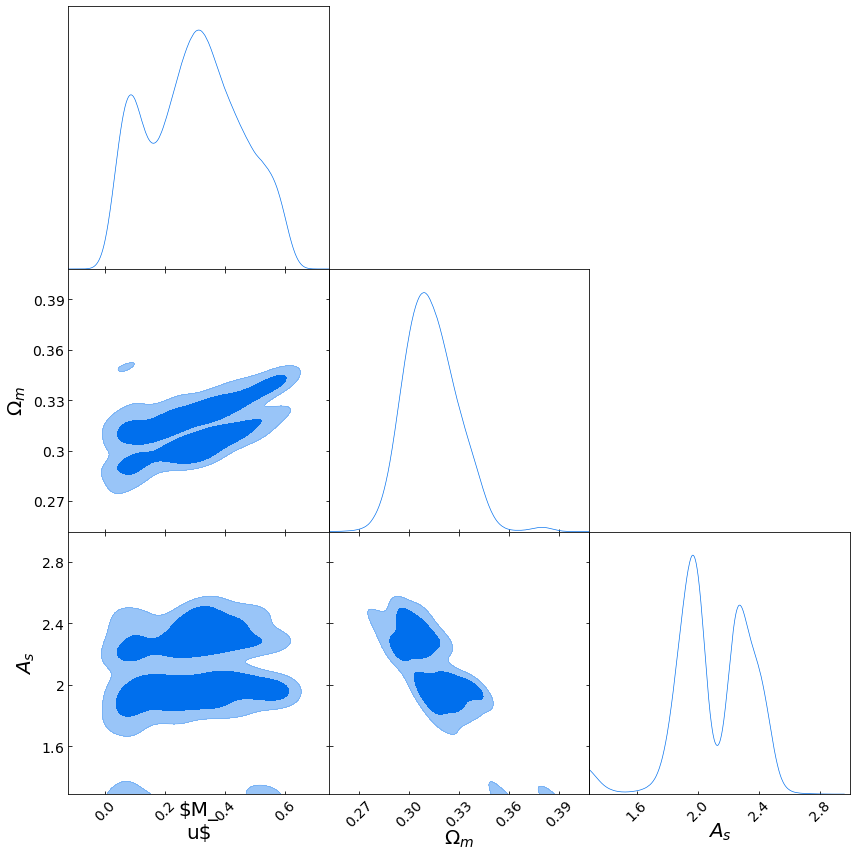

In [20]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])